# Mélanges Gaussiens





Groupe de travail, IRMA, 19 Mai 2021


Algorithme d'apprentissage non supervisé pour partitionner des données (clustering)

**Objectif :** partitionner les **points** $(x_i)_i$ en $K$ **groupes**


- Données : $x_1$,$\ldots$, $x_N$ $\in \mathbb{R}^d$ 

- Sortie : $y_1$,$\ldots$, $y_N$ $\in \{1$,$\ldots$,$K\}$ 

$\to$ *model-free method* : algorithme de $K$-moyenne

$\to$ *model-based method*: mélanges Gaussiens


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

In [16]:
def generate_data(n_samples, K, stretched=True):

    X, y_true = make_blobs(n_samples=500, 
                       centers=K,
                       cluster_std=0.60, 
                       random_state=0)
    X = X[:, ::-1]
    if stretched:
        for k in range(K):
            X[y_true==k,:] = np.dot(X[y_true==k,:], np.random.randn(2, 2))
            
    return X, y_true

In [17]:
def generate_data1(n_samples):

    gaussian1 = np.random.randn(n_samples, 2) + np.array([10, 10])

    C = np.array([[0., -0.7], [3.5, .7]])
    gaussian2 = np.dot(np.random.randn(n_samples, 2), C)
    
    C = np.array([[6., 0.], [0., 1.]])
    gaussian3 = np.dot(np.random.randn(n_samples, 2) , C) + np.array([15,15])
    
    X = np.vstack([gaussian1, gaussian2, gaussian3])                                                                 
            
    return X

Exemples de données :

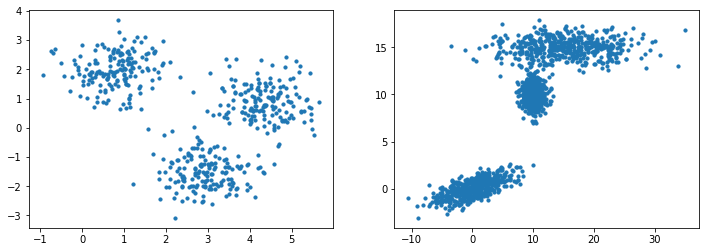

In [18]:
n_samples=500 
K=3

plt.figure(figsize=(12,4))

#------------------------------------------------------
plt.subplot(121)
X, y_true = generate_data(n_samples, K, stretched=False)
kmeans = KMeans(3, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], s=10);

#------------------------------------------------------
plt.subplot(122)
X = generate_data1(n_samples)
kmeans = KMeans(3, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], s=10);

Résultat de l'algorithme de K-moyenne

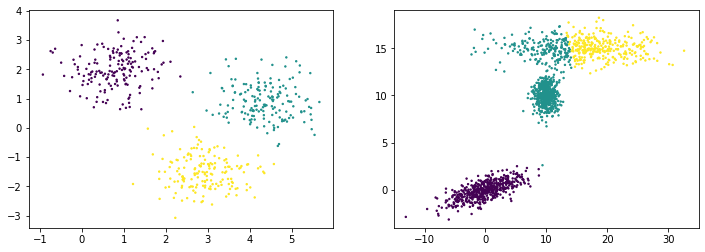

In [19]:
n_samples=500 
K=3

plt.figure(figsize=(12,4))

#------------------------------------------------------
plt.subplot(121)
X, y_true = generate_data(n_samples, K, stretched=False)
kmeans = KMeans(3, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], s=2,c=labels);

#------------------------------------------------------
plt.subplot(122)
X = generate_data1(n_samples)
kmeans = KMeans(3, random_state=0)
labels = kmeans.fit(X).predict(X)
xmin, xmax, ymin, ymax = -15,35,-4,19
plt.axis([xmin, xmax, ymin, ymax])
plt.scatter(X[:, 0], X[:, 1], s=2,c=labels);

Objectifs : 
- groupe de forme plus générale (ellipsoïde)
- donner une probabilité d'appartenance à une classe $\mathbb{P}(y_i = k)$

$\to$ trouver une loi de probabilité de la distribution des points

$\to$ modèle génératif pour créer de nouvelles données

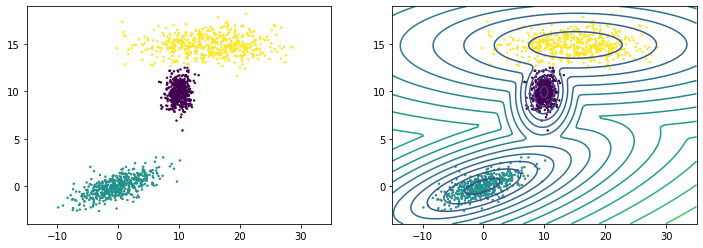

In [20]:
X_train = generate_data1(n_samples)
gmm_clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm_clf.fit(X_train)
labels = gmm_clf.predict(X_train)

plt.figure(figsize=(12,4))
#------------------------------------------------------
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], s=2, c=labels);
plt.axis([xmin, xmax, ymin, ymax])

#------------------------------------------------------
plt.subplot(122)
xmin, xmax, ymin, ymax = -15, 35, -4, 19
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_clf.score_samples(XX)
Z = Z.reshape(X.shape)
plt.axis([xmin, xmax, ymin, ymax])

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 25))

plt.scatter(X_train[:, 0], X_train[:, 1], s=2, c=labels);

## Plan 

1. Mélange Gaussien
2. Algorithme EM
3. Modèle génératif

## 1. Mélange Gaussien

$\quad$

Mélange Gaussien: combinaison convexe de $K$ densités Gaussiennes

$$
\boxed{f_{(\pi,\theta)}(x) = \sum_{k=1}^K \pi_k f_{\theta_k}(x)}
$$



**Paramètres :**  
- poids de la k-ième Gaussienne : $\pi_k$   $\qquad$ $\sum_{k=1}^K \pi_k = 1$
- paramètres de la $k$-ième Gaussienne $\theta_k = (\mu_k, \sigma_k) \in \mathbb{R}^d\times S_d^+(\mathbb{R})$ :

$$f_{\theta_k}(x) = \frac{1}{(2\pi)^{\frac{d}{2}}\det(\sigma_k)^\frac{1}{2} } \exp\left(-\frac{1}{2}(x-\mu_k) \sigma_k^{-1} (x-\mu_k)\right)$$


$\quad$

But : déterminer le jeu de paramètres $\pi = (\pi_k)_k$ et $\theta =(\theta_k)_k$ 

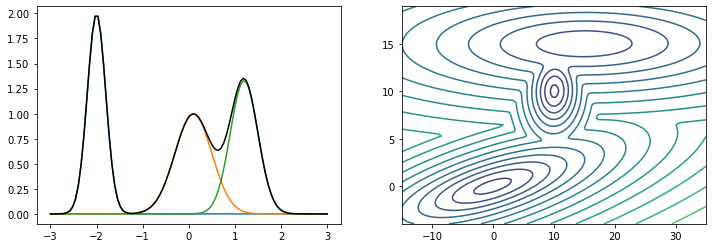

In [152]:
plt.figure(figsize=(12,4))
#------------------------------------------------------
plt.subplot(121)
pi = np.array([0.2,0.3,0.4])
gmean = np.array([-2,0.1,1.2])
gsigma = np.array([0.2,0.4,0.3])
x = np.linspace(-3,3,100)
f = lambda x,gmean,gsigma: np.exp(-(x-gmean)**2/(2*gsigma**2))/np.sqrt(2*np.pi*gsigma**2)

y = np.zeros_like(x)
for k in range(3):
    y += f(x,gmean[k],gsigma[k])
    plt.plot(x,f(x,gmean[k],gsigma[k]))
plt.plot(x,y,'k');

#------------------------------------------------------
plt.subplot(122)
xmin, xmax, ymin, ymax = -15, 35, -4, 19
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.axis([xmin, xmax, ymin, ymax])
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 25))



Modélisation d'un mélange Gaussien : $(X,Y)$ où $X$ représente la donnée et $Y$ l'indice du groupe

$\to$ $Y$ est de loi $(\pi_1,\ldots, \pi_K)$: $\qquad\mathbb{P}(Y = k) = \pi_k$

$\to$ Loi de $X$ conditionnellement à $Y$: $\qquad\mathbb{P}\big(X \in [x, x+dx] | Y = k\big) = f_{\theta_k}(x)\, dx$


Loi jointe de $(X,Y)$ : $$\boxed{\mathbb{P}\big(X \in [x, x+dx], Y = k\big) = \pi_k f_{\theta_k}(x)\, dx}$$



**Observations : $X$**


$$\mathbb{P}(X \in [x, x+dx]) = \sum_{k=1}^K \mathbb{P}\big(X \in [x, x+dx], Y = k\big) = \sum_{k=1}^K \pi_k f_{\theta_k}(x)\, dx = f_{(\pi,\theta)}(x)\, dx$$


**Variable cachée (latente) : $Y$** 

$\qquad$

$\to$ **Probabilité d'appartenance à un groupe donné**

$$
\boxed{\color{blue}{\mathbb{P}\big(Y = j | X \in [x, x+dx]\big)} = \frac{\mathbb{P}(Y=j,X\in [x, x+dx])}{\mathbb{P}(X \in [x, x+dx]))} = \frac{\pi_j f_{\theta_j}(x)}{\sum_{k=1}^K \pi_k f_{\theta_k}(x)}}
$$



## 2. Algorithme EM

$\quad$



Etant donnée les observations $(x_i)$, estimer les paramètres $\pi = (\pi_k)$ et $\theta = (\theta_k)$ 


**Méthode du maximum de vraissemblance**


\begin{align*}
\boxed{\pi, \theta = \text{argmax} \log\left(\mathcal{V}_{\pi,\theta}(x_1,\ldots,x_N)\right)}
\end{align*}

Vraissemblance:
\begin{align*}
\log\left(\mathcal{V}_{\pi,\theta}(x_1,\ldots,x_N)\right) = \log\left(\prod_{i=1}^N f_{(\pi,\theta)}(x_i)\right) =  \log\left(\prod_{i=1}^N \sum_{k=1}^K \pi_k f_{\theta_k}(x_i)\right)
\end{align*}

$\to$ problème difficile 

$\to$ Algorithme EM : Dempster, Laird, Rubin (1977)



**Vraissemblance complète**

\begin{align*}\log\left(\mathcal{V}_{\pi,\theta}\big((x_1,y_1),\ldots,(x_N,y_N)\big)\right) &= \log\left(\prod_{i=1}^N \mathbb{P}(Y=y_i) f_{\theta_{y_i}}(x_i)\right) \\&=  \log\left(\prod_{i=1}^N \pi_{y_i} f_{\theta_{y_i}}(x_i)\right) \\
&=  \sum_{i=1}^N \big(\log  \pi_{y_i} +\log\big(f_{\theta_{y_i}}(x_i)\big)\big)
\end{align*}



$\to$ plus facile à maximiser


Vraissemblance complète moyenne :
\begin{align*}
Q(\pi,\theta|\pi',\theta') &= E_{Y|X,(\pi',\theta')}\left[ \log\mathcal{V}_{\pi,\theta}\big((x_1,y_1),\ldots,(x_N,y_N)\big)\right] \\
&= \sum_{i=1}^N E_{Y|X,(\pi',\theta')}\left[ \log  \pi_{z_i} +\log\big(f_{\theta_{y_i}}(x_i)\big)\right]\\
&= \sum_{i=1}^N \sum_{k = 1}^K  \Big(\log  \pi_{k} +\log\big(f_{\theta_{k}}(x_i)\big)\Big)\, \color{blue}{\mathbb{P}_{Y|X,(\pi',\theta')}(y_i=k)} 
\end{align*}

Par Jensen : $\log\mathcal{V}_{\pi,\theta}\big(x_1,\ldots,x_N)\big) \geqslant Q(\pi,\theta|\pi',\theta') - c(\pi',\theta')$ pour tout $\pi,\theta$

$\to$ Maximiser $Q(\pi,\theta|\pi',\theta')$ permet de maximiser $\log\mathcal{V}_{\pi,\theta}$  



### Algorithme EM

1. **Etape E (expectation/estimation)** :  calculer $\color{blue}{P_{Y|X,(\pi^{(m-1)},\theta^{(m-1)})}(y_i = k) = T_{ik}^{(m-1)}}$ puis déterminer $Q(\pi, \theta|\pi^{(m-1)},\theta^{(m-1)})$

2. **Etape M (maximisation)** : résoudre 

$$\pi^{(m)},\theta^{(m)} = \text{argmax}\ Q(\pi,\theta|\pi^{(m-1)},\theta^{(m-1)})$$

$\quad$

Similaire à l'algorithme de K-moyenne :
1. Attribuer chaque donnée à un groupe
2. Mettre à jour les paramètres de chaque Gaussienne

**Etape M (maximisation)** : explicite pour les Gaussiennes (ici en dimension 1)
    
\begin{align*}
&Q(\pi,\theta|\pi^{(m-1)},\theta^{(m-1)}) = \sum_{i=1}^N \sum_{k = 1}^K  \Big(\log  \pi_{k}^{(m)} +\log\big(f_{\theta_{k}^{(m)}}(x_i)\big)\Big)\, \color{blue}{T_{ik}^{(m-1)}}\\ 
&\qquad = \boxed{\color{red}{\sum_{i=1}^N \sum_{k = 1}^K   \pi_{k} T_{ik}^{(m-1)}} -  \sum_{i=1}^N \sum_{k = 1}^K \frac{1}{2}\log(2\pi \sigma_k) T_{ik}^{(m-1)}  - \sum_{i=1}^N \sum_{k = 1}^K \frac{(x-\mu_k)^2}{2\sigma_k^2} T_{ik}^{(m-1)}} 
\end{align*}

1. Maximimisation du $\color{red}{\text{premier terme}}$ (sous contrainte $\sum_{k=1}^K\pi_k = 1$):$\qquad$  $$\pi_k^{(m)} = \frac{1}{N} \sum_{i=1}^N T_{ik}^{(m-1)}$$

2. Maximimisation des deux autres termes : $\qquad$  $$\mu_k^{(m)} = \frac{ \sum_{i=1}^N T_{ik}^{(m-1)} x_i}{\sum_{i=1}^N T_{ik}^{(m-1)}}\qquad(\sigma_k^{(m)})^2 = \frac{ \sum_{i=1}^N T_{ik}^{(m-1)} \big(x_i-\mu_k^{(m)}\big)^2}{\sum_{i=1}^N T_{ik}^{(m-1)}}$$


**Code Python :** module sklearn (Scikit-learn)

```python
# chargement des données
X_train = generate_data1(n_samples)

# parametrisation du problème  (K=3)
gmm_clf = mixture.GaussianMixture(n_components=3, covariance_type='full')

# résolution du problème
gmm_clf.fit(X_train)

# prédiction
z_predict = gmm_clf.predict([[11.,14.]])
probs_predict = gmm_clf.predict_proba([[11.,14.]])


print('Pour x = (11,14)')
print('----------------')
print('probabilités: ', probs_predict[0] )
print('z prédit: ', z_predict[0] )
```

In [248]:
# chargement des données
X_train = generate_data1(n_samples)

# parametrisation du problème (K=3)
gmm_clf = mixture.GaussianMixture(n_components=3, covariance_type='full')

# résolution du problème 
gmm_clf.fit(X_train)

# prédiction
probs_predict = gmm_clf.predict_proba([[11.,14.]])
z_predict = gmm_clf.predict([[11.,14.]])

print('Pour x = (11,14)')
print('----------------')
print('probabilités: ', probs_predict[0] )
print('z prédit: ', z_predict[0] )

Pour x = (11,14)
----------------
probabilités:  [2.27895518e-52 3.99544760e-03 9.96004552e-01]
z prédit:  2


**Initialisation**

- plusieurs extrema locaux : résultat dépendant de la donnée initiale

- plusieurs initialisations (aléatoire) puis validation croisée




# 3. Modèle génératif

Application sur le  jeu de données `moons` avec $K = 2$

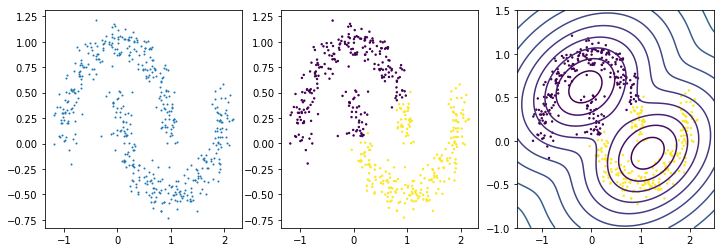

In [30]:
Xmoon, y = make_moons(500, noise=0.1)
gmm_clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm_clf.fit(Xmoon)
labels = gmm_clf.predict(Xmoon)

plt.figure(figsize=(12,4))
#-------------------------------------------------
plt.subplot(131)
plt.scatter(Xmoon[:,0],Xmoon[:,1],s=1);

#------------------------------------------------------
plt.subplot(132)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], s=2, c=labels);

#------------------------------------------------------
plt.subplot(133)
xmin, xmax, ymin, ymax = -1.5, 2.5, -1, 1.5
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 25))

plt.scatter(Xmoon[:, 0], Xmoon[:, 1], s=2, c=labels);

### Variations du nombre de groupes

In [33]:
def plot_gmm(K):
    xmin, xmax, ymin, ymax = -1.5, 2.5, -1, 1.5
    gmm_clf = mixture.GaussianMixture(n_components=K, covariance_type='full')
    gmm_clf.fit(Xmoon)
    labels = gmm_clf.predict(Xmoon)

    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm_clf.score_samples(XX)
    Z = Z.reshape(X.shape)
   
    plt.title('K = '+str(K))
    plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 25));

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  from ipykernel import kernelapp as app


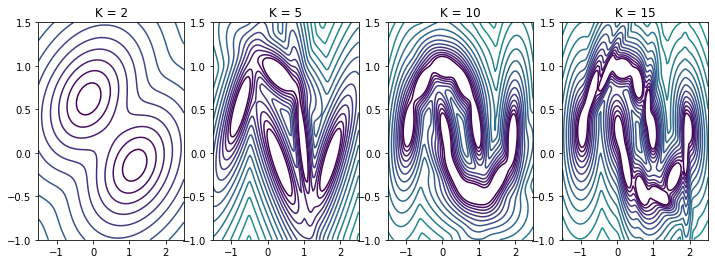

In [36]:
 plt.figure(figsize=(12,4))
#------------------------------------------------------
plt.subplot(141)
plot_gmm(2)

#------------------------------------------------------
plt.subplot(142)
plot_gmm(5)

#------------------------------------------------------
plt.subplot(143)
plot_gmm(10)
#------------------------------------------------------
plt.subplot(144)
plot_gmm(15)


$\to$ sur-apprentissage pour $K$ grand : possibilité d'utiliser des estimateurs (critère d'information d'Akaike information, AIC) pour évaluer l'apprentissage

$$ \text{AIC} = −2 \log\left(\mathcal{V}_{\pi,\theta}(x_1,\ldots,x_N)\right) + 2K$$

### Génération de données

**Code Python :** module sklearn (Scikit-learn)
    
```python
# chargement des données
Xmoon, y = make_moons(500, noise=0.1)

# parametrisation du problème (K=5)
gmm_clf = mixture.GaussianMixture(n_components=5, covariance_type='full')

# résolution du problème
gmm_clf.fit(Xmoon)

# génération
Xnew = gmm_clf.sample(600)[0]

plt.scatter(Xnew[:, 0], Xnew[:, 1], s=2);
```

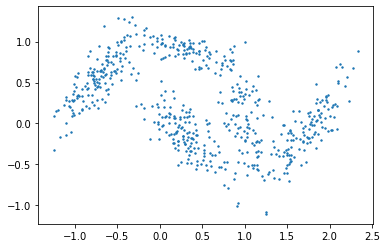

In [247]:
# chargement des données
Xmoon, y = make_moons(500, noise=0.1)

# parametrisation du problème (K=5)
gmm_clf = mixture.GaussianMixture(n_components=5, covariance_type='full')

# résolution du problème 
gmm_clf.fit(Xmoon)

# génération
Xnew = gmm_clf.sample(600)[0]

plt.scatter(Xnew[:, 0], Xnew[:, 1], s=2);

## Références :

-  J. VanderPlas, Python Data Science Handbook
-  S. Donnet, Introduction aux Modèles de mélange et algorithme EM
- M. Crucianu, Reconnaissance des formes et méthodesneuronales (RCP208), Estimation de densité